In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np


In [2]:
# dimensions of our images.
img_width, img_height, n_channels = 64, 64, 3 #TODO change dimensions to be wider, to better support text
train_data_dir = 'D:/MemeMachine_ProjectData/dataset/training'
validation_data_dir = 'D:/MemeMachine_ProjectData/dataset/validation'
epochs = 1 #50 TODO
batch_size = 32

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(img_width*img_height*n_channels, 512),
            # nn.ReLU(),
            # nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, img_width*img_height),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12288, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4096, bias=True)
    (3): Sigmoid()
  )
)


In [4]:
from torch.utils.data import DataLoader
from generate_training_validation_data import CustomImageDataset

#TODO change image_with_text_functions.generate_text_on_image_and_pixel_mask_from_path to place the text properly
train_dataset = CustomImageDataset(train_data_dir, img_width, img_height)
test_dataset = CustomImageDataset(validation_data_dir, img_width, img_height)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, )
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Feature batch shape: torch.Size([32, 3, 64, 64])
Labels batch shape: torch.Size([32, 4096])


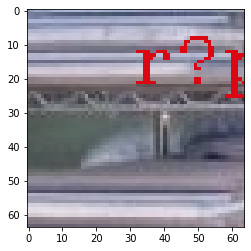

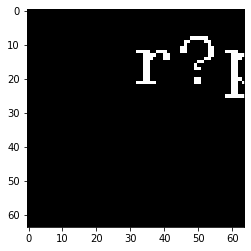

In [5]:
# Display image and label.
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
img = np.moveaxis(img.numpy(), 0, -1)
label = train_labels[0].reshape((img_width, img_height))

plt.imshow(img, cmap="gray")
plt.show()
plt.imshow(label, cmap="gray")
plt.show()


In [6]:
# loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss(reduction='sum')
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred == y).type(torch.float).sum().item() #TODO fix this
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 65564.328125  [    0/36302]
loss: 20.022032  [ 3200/36302]
loss: 17.176474  [ 6400/36302]
loss: 17.603310  [ 9600/36302]
loss: 20.106022  [12800/36302]
loss: 21.219643  [16000/36302]
loss: 18.830318  [19200/36302]
loss: 19.878525  [22400/36302]
loss: 18.894119  [25600/36302]
loss: 18.807844  [28800/36302]
loss: 17.439217  [32000/36302]
loss: 332.443665  [35200/36302]
Test Error: 
 Accuracy: 318070.9%, Avg loss: 30.670033 

Done!


In [10]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Feature batch shape: torch.Size([32, 3, 64, 64])
Labels batch shape: torch.Size([32, 4096])


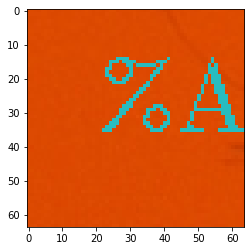

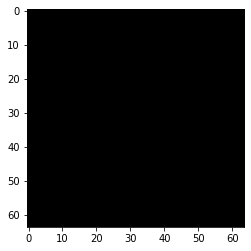

In [11]:

model.eval()
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
    
X, y = train_features.to(device), train_labels.to(device)
pred = model(X)

img = train_features[0].squeeze()
img = np.moveaxis(img.numpy(), 0, -1)
label = pred[0].detach().numpy().reshape((img_width, img_height))

plt.imshow(img, cmap="gray")
plt.show()
plt.imshow(label, cmap="gray")
plt.show()
